# Twitter Social Network Analysis: Temporal Sentiment and Influence Tracking

This notebook demonstrates a comprehensive social network analysis of Twitter data, focusing on:

1. **Temporal Graph Construction** - Building dynamic social networks from user interactions
2. **Sentiment Analysis** - Using VADER to track opinion evolution over time
3. **Influence Measurement** - Identifying key users through centrality metrics
4. **Community Detection** - Finding clusters of users with similar behavior
5. **Visualization** - Creating comprehensive plots and interactive dashboards

## Dataset: Business-Related Twitter Discussions
We analyze 14,189 tweets to identify influential users in business conversations using classical SNA techniques (no ML/DL).

## 1. Setup and Data Loading

In [2]:
# Import required libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('../src')

# Import our custom modules
from preprocess import TwitterDataPreprocessor
from build_graph import TemporalGraphBuilder
from sentiment_analysis import TwitterSentimentAnalyzer
from visualization import TwitterVisualization

# Standard libraries
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

print("✅ All modules imported successfully!")
print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All modules imported successfully!
📅 Analysis started at: 2025-06-20 11:07:22


## 2. Data Preprocessing

In [3]:
# Initialize data preprocessor
print("🔄 Loading and preprocessing Twitter data...")
preprocessor = TwitterDataPreprocessor("../data/tweetdata-en.csv")

# Load the dataset
raw_data = preprocessor.load_data()

# Check if data loaded successfully
if raw_data is None:
    print("❌ Failed to load data. Please check the file path.")
else:
    # Display basic dataset information
    print(f"\n📊 Dataset Overview:")
    print(f"Total tweets: {len(raw_data):,}")
    print(f"Columns: {list(raw_data.columns)}")

    # Check date range using the actual column name
    if 'createdAt' in raw_data.columns:
        # Parse dates to get proper range
        dates = pd.to_datetime(raw_data['createdAt'], errors='coerce')
        print(f"Date range: {dates.min()} to {dates.max()}")
        print(f"Valid dates: {dates.notna().sum():,}")
    else:
        print("Date column 'createdAt' not found")

    # Show basic data info
    print(f"\nData types overview:")
    print(f"  Text field: {raw_data['text'].dtype}")
    print(f"  Author field: {raw_data['author'].dtype}")
    print(f"  Date field: {raw_data['createdAt'].dtype}")

    # Extract sample user info for display
    print("\n📋 Sample tweets with user info:")
    sample_data = []
    for idx in range(min(5, len(raw_data))):
        row = raw_data.iloc[idx]
        
        # Extract user info from author field
        author_info = preprocessor.parse_author_info(row.get('author', ''))
        
        sample_data.append({
            'tweet_id': str(row.get('id', 'N/A')),
            'user_id': author_info.get('user_id', 'N/A'),
            'username': author_info.get('username', 'N/A'),
            'text': str(row.get('text', ''))[:80] + '...' if len(str(row.get('text', ''))) > 80 else str(row.get('text', '')),
            'created_at': str(row.get('createdAt', 'N/A'))[:19],  # Truncate timestamp
            'is_reply': row.get('isReply', False),
            'is_quote': row.get('isQuote', False),
            'like_count': row.get('likeCount', 0),
            'retweet_count': row.get('retweetCount', 0)
        })

    # Display as DataFrame for better formatting
    sample_df = pd.DataFrame(sample_data)
    print(sample_df[['username', 'text', 'like_count']].to_string(index=False))

    # Show interaction statistics
    print(f"\n🔗 Interaction Overview:")
    print(f"  Total tweets: {len(raw_data):,}")
    print(f"  Replies: {raw_data['isReply'].sum() if 'isReply' in raw_data.columns else 'N/A'}")
    print(f"  Quotes: {raw_data['isQuote'].sum() if 'isQuote' in raw_data.columns else 'N/A'}")
    print(f"  Has reply-to info: {raw_data['inReplyToUserId'].notna().sum() if 'inReplyToUserId' in raw_data.columns else 'N/A'}")

    # Show engagement statistics
    engagement_cols = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount']
    print(f"\n📊 Engagement Statistics:")
    for col in engagement_cols:
        if col in raw_data.columns:
            mean_val = raw_data[col].mean()
            max_val = raw_data[col].max()
            print(f"  {col:<15}: avg {mean_val:.1f}, max {max_val:,}")

    # Show sample author field structure
    print(f"\n👤 Sample Author Field Structure:")
    if not raw_data['author'].isna().all():
        sample_author = raw_data['author'].dropna().iloc[0]
        print(f"Type: {type(sample_author)}")
        print(f"Sample content (first 200 chars): {str(sample_author)[:200]}...")
        
        # Test parsing
        test_parse = preprocessor.parse_author_info(sample_author)
        print(f"Parsed result: {test_parse}")

🔄 Loading and preprocessing Twitter data...
✅ Loaded 14,189 tweets from ../data/tweetdata-en.csv
📋 Columns available: ['Unnamed: 0', 'type', 'id', 'url', 'twitterUrl', 'text', 'source', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang', 'bookmarkCount', 'isReply', 'inReplyToId', 'conversationId', 'inReplyToUserId', 'inReplyToUsername', 'isPinned', 'author', 'extendedEntities', 'card', 'place', 'entities', 'reply_to_user_results', 'quoted_tweet_results', 'quoted_tweet', 'retweeted_tweet', 'isConversationControlled', 'searchTermIndex', 'isQuote']

📊 Dataset Overview:
Total tweets: 14,189
Columns: ['Unnamed: 0', 'type', 'id', 'url', 'twitterUrl', 'text', 'source', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang', 'bookmarkCount', 'isReply', 'inReplyToId', 'conversationId', 'inReplyToUserId', 'inReplyToUsername', 'isPinned', 'author', 'extendedEntities', 'card', 'place', 'entities', 'reply_to_user_results', 'q

In [5]:
# Process data and extract users/interactions
print("\n🔄 Processing data and extracting interactions...")
users, interactions = preprocessor.process_data(filter_business=False)

print(f"\n✅ Data Processing Complete:")
print(f"👥 Unique users extracted: {len(users):,}")
print(f"🔗 Valid interactions found: {len(interactions):,}")

# Show interaction type breakdown
interaction_types = {}
for interaction in interactions:
    edge_type = interaction['edge_type']
    interaction_types[edge_type] = interaction_types.get(edge_type, 0) + 1

print("\n📈 Interaction Type Distribution:")
for edge_type, count in sorted(interaction_types.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(interactions)) * 100
    print(f"  {edge_type.capitalize()}: {count:,} ({percentage:.1f}%)")

# Display sample users
print("\n👤 Sample User Profiles:")
sample_users = list(users.items())[:5]
for user_id, user_info in sample_users:
    print(f"  @{user_info['username']}: {user_info['followers_count']:,} followers, {user_info['name']}")


🔄 Processing data and extracting interactions...
📤 Extracting user information...
👥 Extracted 8053 new users, total: 8053
🔗 Extracting interactions...
📊 Extracted 14590 total interactions
✅ Processing complete:
   Users: 8,053
   Valid interactions: 1,824
   Removed invalid interactions: 12,766

📈 Interaction type breakdown:
   Mention: 1,824 (100.0%)

✅ Data Processing Complete:
👥 Unique users extracted: 8,053
🔗 Valid interactions found: 1,824

📈 Interaction Type Distribution:
  Mention: 1,824 (100.0%)

👤 Sample User Profiles:
  @isutechzone: 699 followers, TechZone
  @ichbinichnich: 44 followers, Gabi Peyn
  @newslisted: 103 followers, News
  @bruhitsapple: 584 followers, apple
  @solarheavy: 67,311 followers, Solar Heavy


## 3. Temporal Graph Construction

In [6]:
# Initialize graph builder
print("🔄 Building temporal social graphs...")
graph_builder = TemporalGraphBuilder(users, interactions)

# Create the full network graph
full_graph = graph_builder.create_full_graph()

# Get basic network statistics
network_stats = graph_builder.get_network_statistics()
print(f"\n📊 Network Statistics:")
for metric, value in network_stats.items():
    if isinstance(value, float):
        print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"  {metric.replace('_', ' ').title()}: {value:,}")

🔄 Building temporal social graphs...
Created full graph with 8053 nodes and 1561 edges

📊 Network Statistics:
  Nodes: 8,053
  Edges: 1,561
  Density: 0.0000
  Average Clustering: 0.0112
  Average Degree: 0.3877
  Max Degree: 94
  Min Degree: 0


In [7]:
# Create temporal snapshots
print("\n🔄 Creating daily temporal snapshots...")
temporal_graphs = graph_builder.create_temporal_snapshots(interval='daily')

print(f"\n⏰ Temporal Analysis:")
print(f"  Total snapshots created: {len(temporal_graphs)}")
print(f"  Time range: {min(temporal_graphs.keys())} to {max(temporal_graphs.keys())}")

# Show snapshot statistics
snapshot_stats = []
for time_key, graph in temporal_graphs.items():
    snapshot_stats.append({
        'date': time_key,
        'nodes': graph.number_of_nodes(),
        'edges': graph.number_of_edges(),
        'density': nx.density(graph)
    })

snapshot_df = pd.DataFrame(snapshot_stats)
print(f"\n📈 Temporal Snapshot Summary:")
print(f"  Average nodes per day: {snapshot_df['nodes'].mean():.1f}")
print(f"  Average edges per day: {snapshot_df['edges'].mean():.1f}")
print(f"  Average density: {snapshot_df['density'].mean():.4f}")

# Display top active days
top_days = snapshot_df.nlargest(5, 'edges')
print(f"\n🔥 Most Active Days (by interactions):")
for _, row in top_days.iterrows():
    print(f"  {row['date']}: {row['edges']} interactions, {row['nodes']} users")


🔄 Creating daily temporal snapshots...
Created 90 temporal snapshots

⏰ Temporal Analysis:
  Total snapshots created: 90
  Time range: 2024-11-13_19-21 to 2025-04-19_19-21

📈 Temporal Snapshot Summary:
  Average nodes per day: 24.1
  Average edges per day: 15.7
  Average density: 0.0567

🔥 Most Active Days (by interactions):
  2025-03-25_19-21: 56 interactions, 85 users
  2025-02-18_19-21: 53 interactions, 65 users
  2025-03-24_19-21: 50 interactions, 67 users
  2025-02-20_19-21: 41 interactions, 61 users
  2025-03-20_19-21: 37 interactions, 55 users


## 4. Centrality Analysis and Influence Ranking

In [8]:
# Calculate centrality metrics
print("🔄 Calculating centrality metrics...")
centrality_metrics = graph_builder.calculate_centrality_metrics()

# Get top influential users by different metrics
influence_metrics = ['pagerank', 'in_degree_centrality', 'out_degree_centrality']

print("\n🏆 Top Influential Users by Different Met  grics:")
for metric in influence_metrics:
    print(f"\n📊 Top 10 by {metric.replace('_', ' ').title()}:")
    top_users = graph_builder.get_influential_users(top_k=10, metric=metric)
    
    for i, (user_id, score) in enumerate(top_users, 1):
        user_info = users.get(user_id, {})
        username = user_info.get('username', 'unknown')
        name = user_info.get('name', 'Unknown')
        followers = user_info.get('followers_count', 0)
        print(f"  {i:2d}. @{username:<15} | {name:<20} | {score:.4f} | {followers:,} followers")

🔄 Calculating centrality metrics...

🏆 Top Influential Users by Different Met  grics:

📊 Top 10 by Pagerank:
   1. @markgurman      | Mark Gurman          | 0.0116 | 407,404 followers
   2. @datruthdt       | DaTruthDT            | 0.0057 | 263,932 followers
   3. @theapplehub     | Apple Hub            | 0.0043 | 1,185,790 followers
   4. @sinnybd         | ❄️SinnyBD❄️          | 0.0034 | 1,693 followers
   5. @grok            | Grok                 | 0.0034 | 3,469,363 followers
   6. @eth_apple       | APPLE🔺L1             | 0.0030 | 185,702 followers
   7. @passi0n03       | y - Passion (1-0)    | 0.0030 | 1,399 followers
   8. @macrumors       | MacRumors.com        | 0.0026 | 1,340,159 followers
   9. @ronin_network   | Ronin                | 0.0025 | 266,863 followers
  10. @gaminggridx     | GamingGrid 💎         | 0.0025 | 22,982 followers

📊 Top 10 by In Degree Centrality:
   1. @markgurman      | Mark Gurman          | 0.0117 | 407,404 followers
   2. @datruthdt       | DaTru

In [7]:
# Analyze temporal influence patterns
print("\n🔄 Analyzing temporal influence patterns...")
temporal_influence_df = graph_builder.analyze_temporal_influence()

if not temporal_influence_df.empty:
    print(f"\n⏰ Temporal Influence Analysis:")
    print(f"  Total user-time observations: {len(temporal_influence_df):,}")
    print(f"  Unique users tracked: {temporal_influence_df['user_id'].nunique():,}")
    print(f"  Time periods: {temporal_influence_df['timestamp'].nunique()}")
    
    # Show users with most consistent high influence
    user_avg_influence = temporal_influence_df.groupby('user_id')['pagerank'].agg(['mean', 'std', 'count']).reset_index()
    user_avg_influence['consistency'] = user_avg_influence['mean'] / (user_avg_influence['std'] + 0.001)  # Avoid division by zero
    
    most_consistent = user_avg_influence[user_avg_influence['count'] >= 3].nlargest(10, 'consistency')
    print(f"\n🎯 Most Consistently Influential Users:")
    for _, row in most_consistent.iterrows():
        user_info = users.get(row['user_id'], {})
        username = user_info.get('username', 'unknown')
        print(f"  @{username:<15} | Avg: {row['mean']:.4f} | Consistency: {row['consistency']:.2f}")
else:
    print("❌ No temporal influence data available")


🔄 Analyzing temporal influence patterns...

⏰ Temporal Influence Analysis:
  Total user-time observations: 2,168
  Unique users tracked: 1,243
  Time periods: 90

🎯 Most Consistently Influential Users:
  @lakshyalark     | Avg: 0.0245 | Consistency: 7.71
  @axellont1       | Avg: 0.0988 | Consistency: 6.58
  @kanthan2030     | Avg: 0.0733 | Consistency: 4.68
  @num1mephilesfan | Avg: 0.0272 | Consistency: 4.22
  @sdw             | Avg: 0.0447 | Consistency: 4.08
  @marionawfal     | Avg: 0.0497 | Consistency: 3.54
  @tylerdbzboi     | Avg: 0.0154 | Consistency: 3.48
  @twostraws       | Avg: 0.0446 | Consistency: 3.46
  @paytondev       | Avg: 0.0279 | Consistency: 3.33
  @finsavvymike    | Avg: 0.0196 | Consistency: 3.23


## 5. Community Detection

In [8]:
# Detect communities
print("🔄 Detecting communities using modularity optimization...")
communities = graph_builder.detect_communities()

if communities:
    # Analyze community structure
    community_sizes = pd.Series(communities.values()).value_counts().sort_values(ascending=False)
    
    print(f"\n🏘️ Community Detection Results:")
    print(f"  Total communities found: {len(community_sizes)}")
    print(f"  Largest community: {community_sizes.iloc[0]} users")
    print(f"  Smallest community: {community_sizes.iloc[-1]} users")
    print(f"  Average community size: {community_sizes.mean():.1f} users")
    
    print(f"\n📊 Community Size Distribution:")
    for i, (community_id, size) in enumerate(community_sizes.head(10).items()):
        print(f"  Community {community_id}: {size} users")
    
    # Show sample users from largest communities
    print(f"\n👥 Sample Users from Largest Communities:")
    for community_id in community_sizes.head(3).index:
        community_users = [user_id for user_id, comm_id in communities.items() if comm_id == community_id]
        sample_users = community_users[:5]  # Show first 5 users
        
        print(f"\n  Community {community_id} ({len(community_users)} users):")
        for user_id in sample_users:
            user_info = users.get(user_id, {})
            username = user_info.get('username', 'unknown')
            name = user_info.get('name', 'Unknown')
            print(f"    @{username} - {name}")
else:
    print("❌ No communities detected")

🔄 Detecting communities using modularity optimization...
Detected 6850 communities

🏘️ Community Detection Results:
  Total communities found: 6850
  Largest community: 155 users
  Smallest community: 1 users
  Average community size: 1.2 users

📊 Community Size Distribution:
  Community 0: 155 users
  Community 1: 133 users
  Community 2: 113 users
  Community 3: 85 users
  Community 4: 65 users
  Community 5: 61 users
  Community 6: 47 users
  Community 7: 28 users
  Community 8: 23 users
  Community 9: 20 users

👥 Sample Users from Largest Communities:

  Community 0 (155 users):
    @jeremiahro85829 - Jeremiah Rodriguez
    @_halvard - Halvard
    @bbbabuser - Alex
    @driplor31643186 - Drip Ningen ||😈🔥🗿||
    @jo_2618 - Jo

  Community 1 (133 users):
    @abegg_gauthey - _AG
    @kritikalj_00 - KritikalJ
    @jeremylshow - Jeremy Allen
    @bxlewi1 - Han MF Brolo
    @cro_conaut - koloxarto

  Community 2 (113 users):
    @dotavocado - avocado
    @floppayona77617 - CreeperPower5

## 6. Sentiment Analysis

In [9]:
# Initialize sentiment analyzer
print("🔄 Analyzing sentiment of Apple-related tweets using VADER...")
sentiment_analyzer = TwitterSentimentAnalyzer()

# Get ALL tweets for sentiment analysis (since they're all Apple-related)
all_tweets = preprocessor.get_processed_tweets()
print(f"Apple-related tweets for sentiment analysis: {len(all_tweets):,}")

# Analyze sentiment
sentiment_df = sentiment_analyzer.analyze_dataset_sentiment(all_tweets, text_column='text')

🔄 Analyzing sentiment of Apple-related tweets using VADER...
Apple-related tweets for sentiment analysis: 14,189
Analyzing sentiment for 14189 tweets...

Sentiment Analysis Summary:
Total tweets analyzed: 14189
Sentiment distribution:
  Positive: 7451 (52.5%)
  Neutral: 3985 (28.1%)
  Negative: 2753 (19.4%)

Average sentiment scores:
  Compound: 0.207
  Positive: 0.099
  Negative: 0.044
  Neutral: 0.857


In [10]:
# Temporal sentiment analysis
print("\n🔄 Analyzing temporal sentiment patterns...")
temporal_sentiment = sentiment_analyzer.analyze_temporal_sentiment(sentiment_df, interval='daily')

if not temporal_sentiment.empty:
    print(f"\n📈 Temporal Sentiment Summary:")
    print(f"  Time periods analyzed: {len(temporal_sentiment)}")
    print(f"  Overall average sentiment: {sentiment_df['compound'].mean():.3f}")
    print(f"  Sentiment volatility: {sentiment_df['compound'].std():.3f}")
    
    # Show days with extreme sentiment
    most_positive_day = temporal_sentiment.loc[temporal_sentiment['avg_compound'].idxmax()]
    most_negative_day = temporal_sentiment.loc[temporal_sentiment['avg_compound'].idxmin()]
    
    print(f"\n🌟 Most Positive Day: {most_positive_day['time_period']}")
    print(f"     Avg Sentiment: {most_positive_day['avg_compound']:.3f}")
    print(f"     Tweets: {most_positive_day['total_tweets']}")
    
    print(f"\n⛈️  Most Negative Day: {most_negative_day['time_period']}")
    print(f"     Avg Sentiment: {most_negative_day['avg_compound']:.3f}")
    print(f"     Tweets: {most_negative_day['total_tweets']}")
else:
    print("❌ No temporal sentiment data available")


🔄 Analyzing temporal sentiment patterns...
Created temporal sentiment analysis for 100 time periods

📈 Temporal Sentiment Summary:
  Time periods analyzed: 100
  Overall average sentiment: 0.207
  Sentiment volatility: 0.441

🌟 Most Positive Day: 2024-09-13
     Avg Sentiment: 0.904
     Tweets: 1

⛈️  Most Negative Day: 2025-01-02
     Avg Sentiment: -0.307
     Tweets: 1


In [11]:
# User sentiment patterns
print("\n🔄 Analyzing user sentiment patterns...")
user_patterns = sentiment_analyzer.analyze_user_sentiment_patterns(sentiment_df)

if not user_patterns.empty:
    print(f"\n👤 User Sentiment Patterns:")
    print(f"  Users analyzed: {len(user_patterns)}")
    
    # Show most positive and negative users
    most_positive_users = user_patterns.nlargest(5, 'avg_compound')
    most_negative_users = user_patterns.nsmallest(5, 'avg_compound')
    
    print(f"\n😊 Most Positive Users:")
    for _, user in most_positive_users.iterrows():
        print(f"  @{user['username']:<15} | Avg: {user['avg_compound']:.3f} | Tweets: {user['total_tweets']}")
    
    print(f"\n😤 Most Negative Users:")
    for _, user in most_negative_users.iterrows():
        print(f"  @{user['username']:<15} | Avg: {user['avg_compound']:.3f} | Tweets: {user['total_tweets']}")
    
    # Show most consistent users
    most_consistent_sentiment = user_patterns.nlargest(5, 'consistency_score')
    print(f"\n🎯 Most Consistent Users (sentiment-wise):")
    for _, user in most_consistent_sentiment.iterrows():
        print(f"  @{user['username']:<15} | Consistency: {user['consistency_score']:.3f} | Dominant: {user['dominant_sentiment']}")
else:
    print("❌ No user sentiment patterns available")


🔄 Analyzing user sentiment patterns...
Analyzed sentiment patterns for 1444 users

👤 User Sentiment Patterns:
  Users analyzed: 1444

😊 Most Positive Users:
  @sevenxtrem68    | Avg: 0.991 | Tweets: 2
  @wuyikiwi        | Avg: 0.987 | Tweets: 2
  @jeffreyjmatte   | Avg: 0.986 | Tweets: 2
  @randylollini    | Avg: 0.985 | Tweets: 2
  @fnsnoctisevents | Avg: 0.982 | Tweets: 2

😤 Most Negative Users:
  @craigberar46301 | Avg: -0.922 | Tweets: 2
  @tradingguru     | Avg: -0.884 | Tweets: 2
  @o161531794      | Avg: -0.883 | Tweets: 2
  @jasmin_25_90    | Avg: -0.882 | Tweets: 2
  @eggstal_        | Avg: -0.803 | Tweets: 2

🎯 Most Consistent Users (sentiment-wise):
  @markbro28147884 | Consistency: 1.000 | Dominant: positive
  @tanaysinght     | Consistency: 1.000 | Dominant: neutral
  @aniplaylist     | Consistency: 1.000 | Dominant: neutral
  @laurentgiret    | Consistency: 1.000 | Dominant: negative
  @insidemacintosh | Consistency: 1.000 | Dominant: neutral


In [12]:
# Get sentiment extremes
extremes = sentiment_analyzer.get_sentiment_extremes(sentiment_df, top_k=3)

print("\n🏆 Most Extreme Tweets:")
print("\n😍 Most Positive Tweets:")
for idx, row in extremes['most_positive'].iterrows():
    print(f"  Score: {row['compound']:.3f} | @{row['username']}")
    print(f"  Text: {row['text'][:100]}...\n")

print("\n😡 Most Negative Tweets:")
for idx, row in extremes['most_negative'].iterrows():
    print(f"  Score: {row['compound']:.3f} | @{row['username']}")
    print(f"  Text: {row['text'][:100]}...\n")


🏆 Most Extreme Tweets:

😍 Most Positive Tweets:
  Score: 0.997 | @blokeman00
  Text: To make REE supply lucrative, the U.S. can structure a multifaceted package for Greenland and Denmar...

  Score: 0.996 | @thepost_card
  Text: iPhone 16e launch, what to expect, and why it makes or doesn't make sense?🍎📱  

🌟 What’s the iPhone ...

  Score: 0.995 | @pensacola_x
  Text: EVENT ANNOUNCEMENT: A Tech Anniversary Worth Celebrating!

April 11, 1976 — the day that changed the...


😡 Most Negative Tweets:
  Score: -0.994 | @omicemperor
  Text: if we strictly apply Reagan’s logic ("debt comes from spending too much, not insufficient revenue"),...

  Score: -0.990 | @kendogunsop
  Text: Resident Evil 3 Remake is now available today on iPhone 16, iPhone 15 Pro, iPads and Macs with the M...

  Score: -0.989 | @billwallaceusa
  Text: $SWKS Skyworks Solutions Inc. 

Skyworks Is Getting Hit From All Sides — And the Worst May Still Be ...



## 7. Comprehensive Visualizations

In [13]:
# Initialize visualization module
print("🔄 Creating comprehensive visualizations...")
viz = TwitterVisualization(figsize=(12, 8))

# Create output directory for plots
os.makedirs('../plots', exist_ok=True)

print("📊 Generating visualization suite...")

🔄 Creating comprehensive visualizations...
📊 Generating visualization suite...



📈 Creating temporal sentiment visualization...
Saved temporal sentiment plot to ../plots/temporal_sentiment.png


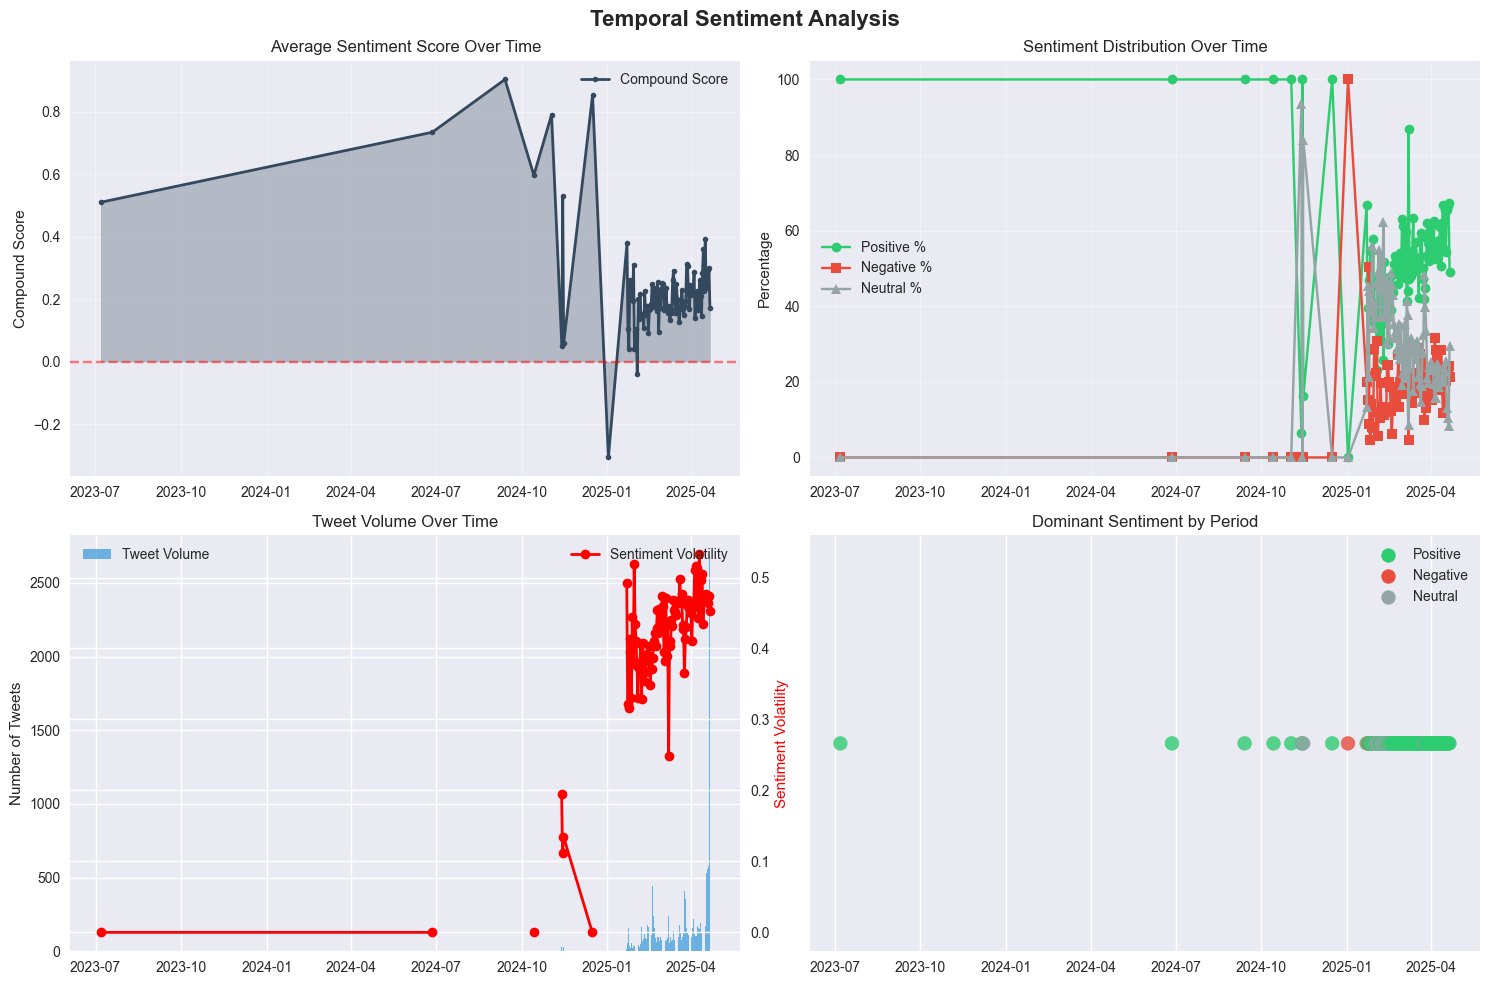

In [14]:
# 1. Temporal Sentiment Analysis
if not temporal_sentiment.empty:
    print("\n📈 Creating temporal sentiment visualization...")
    fig1 = viz.plot_temporal_sentiment(temporal_sentiment, save_path='../plots/temporal_sentiment.png')
    plt.show()
else:
    print("⚠️ Skipping temporal sentiment plot - no data")


👤 Creating user sentiment patterns visualization...
Saved user sentiment patterns plot to ../plots/user_sentiment_patterns.png


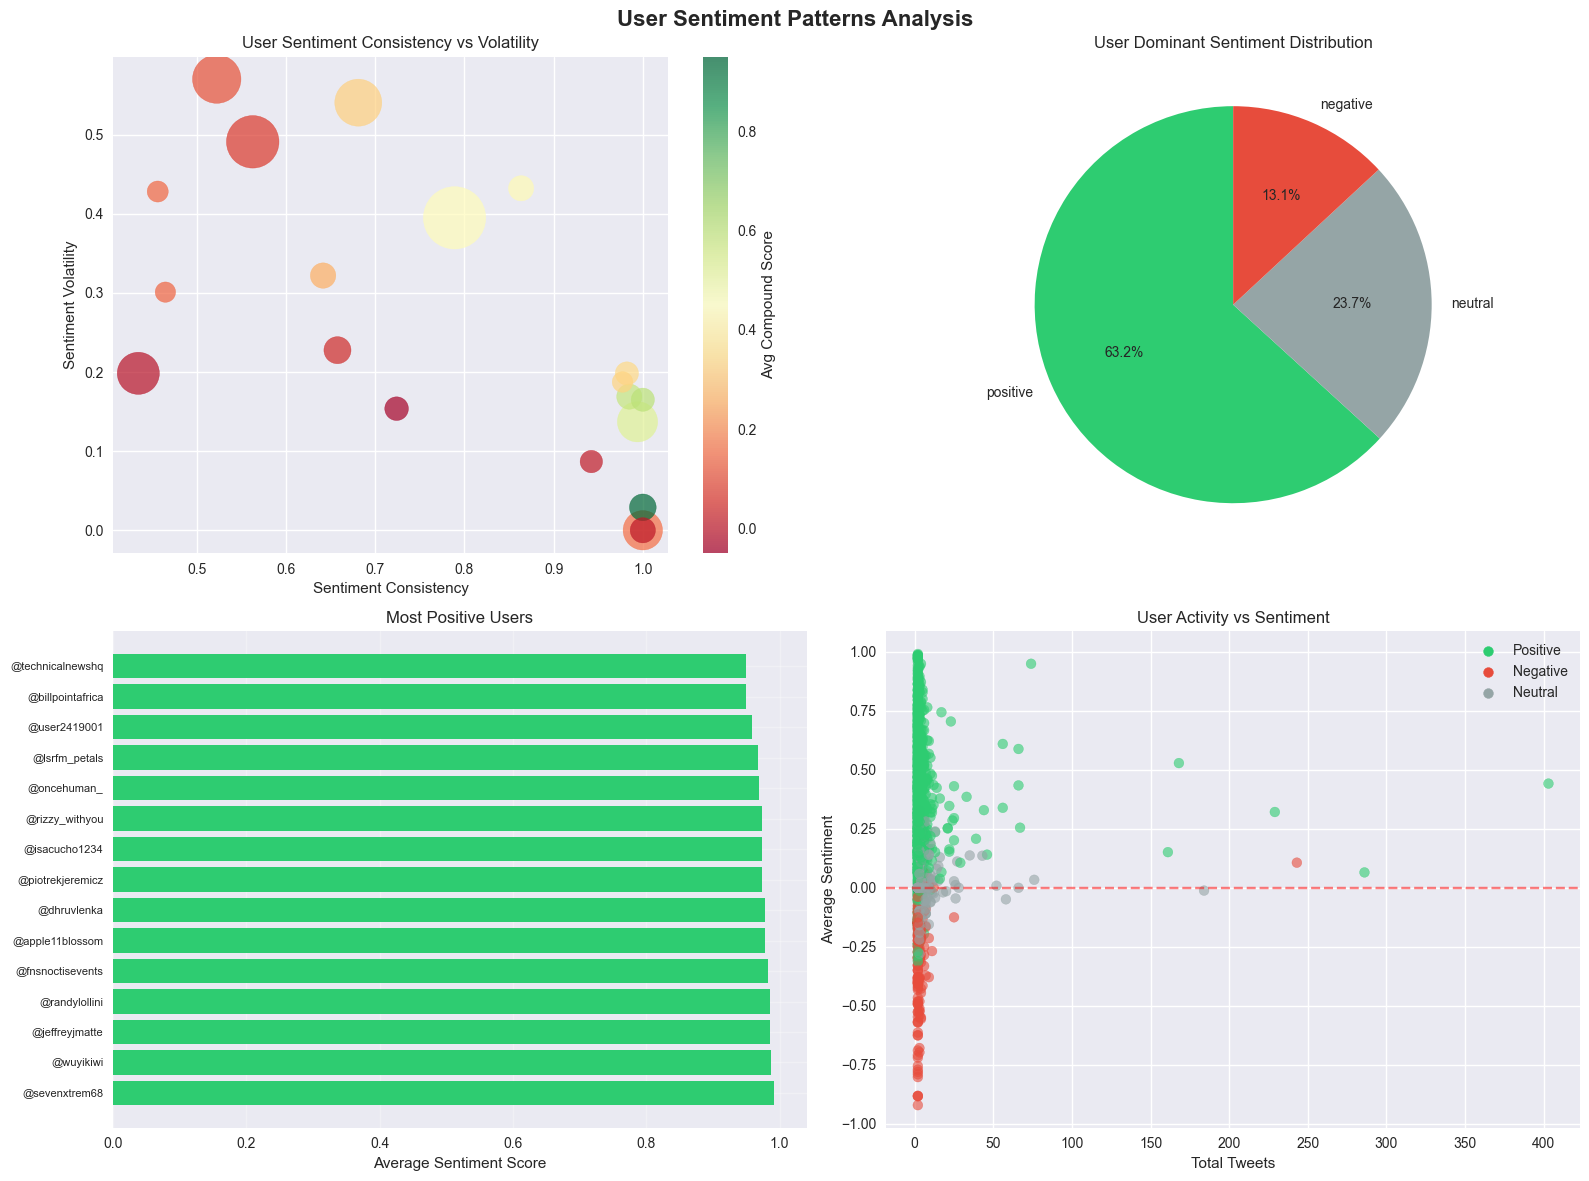

In [15]:
# 2. User Sentiment Patterns
if not user_patterns.empty:
    print("\n👤 Creating user sentiment patterns visualization...")
    fig2 = viz.plot_user_sentiment_patterns(user_patterns, top_n=20, save_path='../plots/user_sentiment_patterns.png')
    plt.show()
else:
    print("⚠️ Skipping user sentiment patterns plot - no data")


🕸️ Creating network graph visualization...
Visualizing all 8053 nodes
Saved network graph to ../plots/network_graph.png


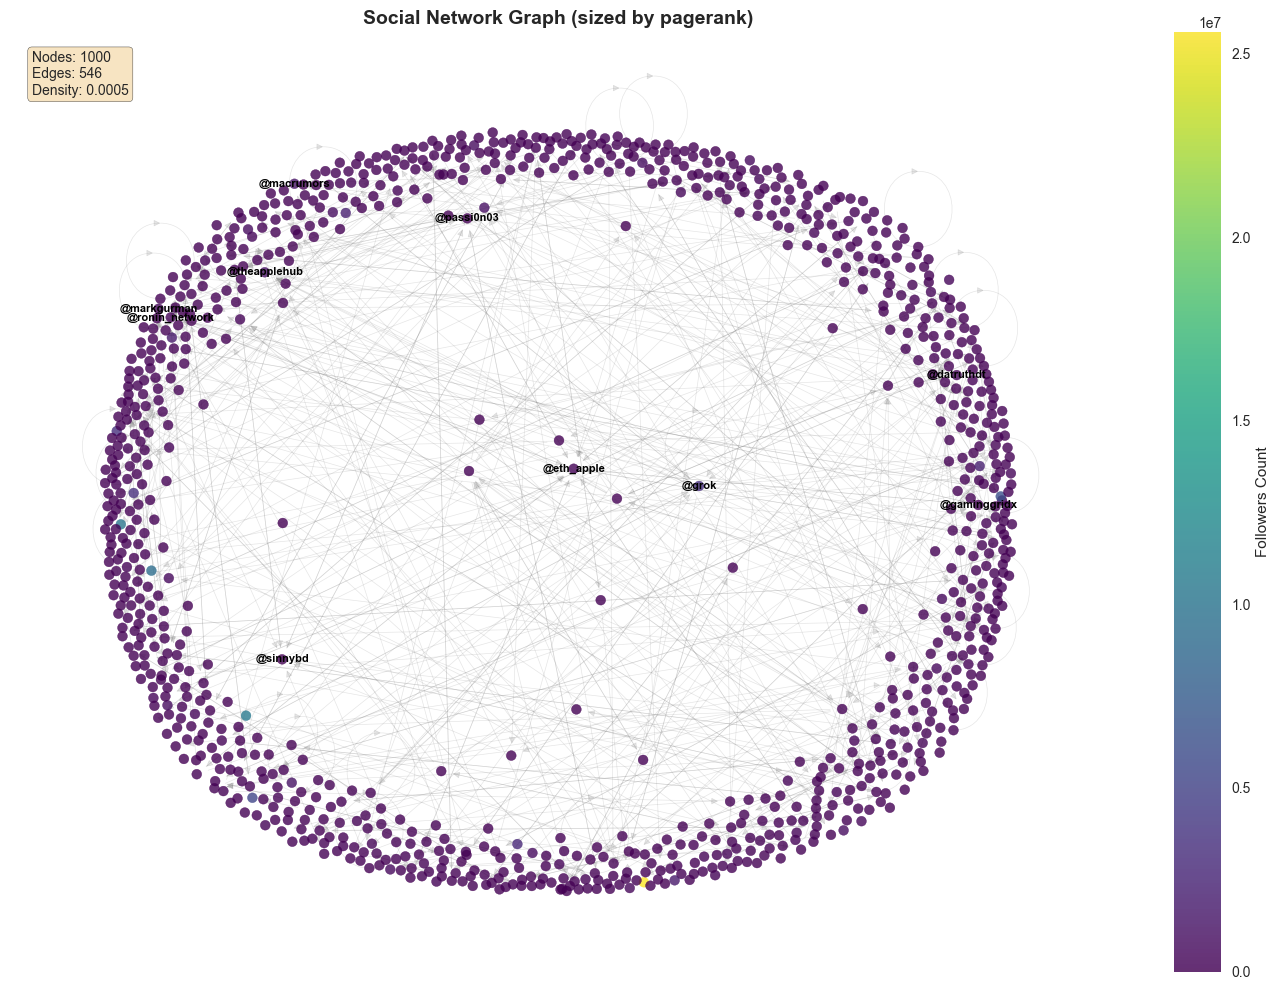

In [18]:
# 3. Network Graph Visualization
if full_graph and full_graph.number_of_nodes() > 0:
    print("\n🕸️ Creating network graph visualization...")
    total_nodes = full_graph.number_of_nodes()
    print(f"Visualizing all {total_nodes} nodes")
    
    fig3 = viz.plot_network_graph(full_graph, layout='spring', node_size_metric='pagerank', 
                                  top_nodes=1000, save_path='../plots/network_graph.png')
    plt.show()
else:
    print("⚠️ Skipping network graph plot - no graph data")


🏆 Creating centrality rankings visualization...
Saved centrality rankings plot to ../plots/centrality_rankings.png


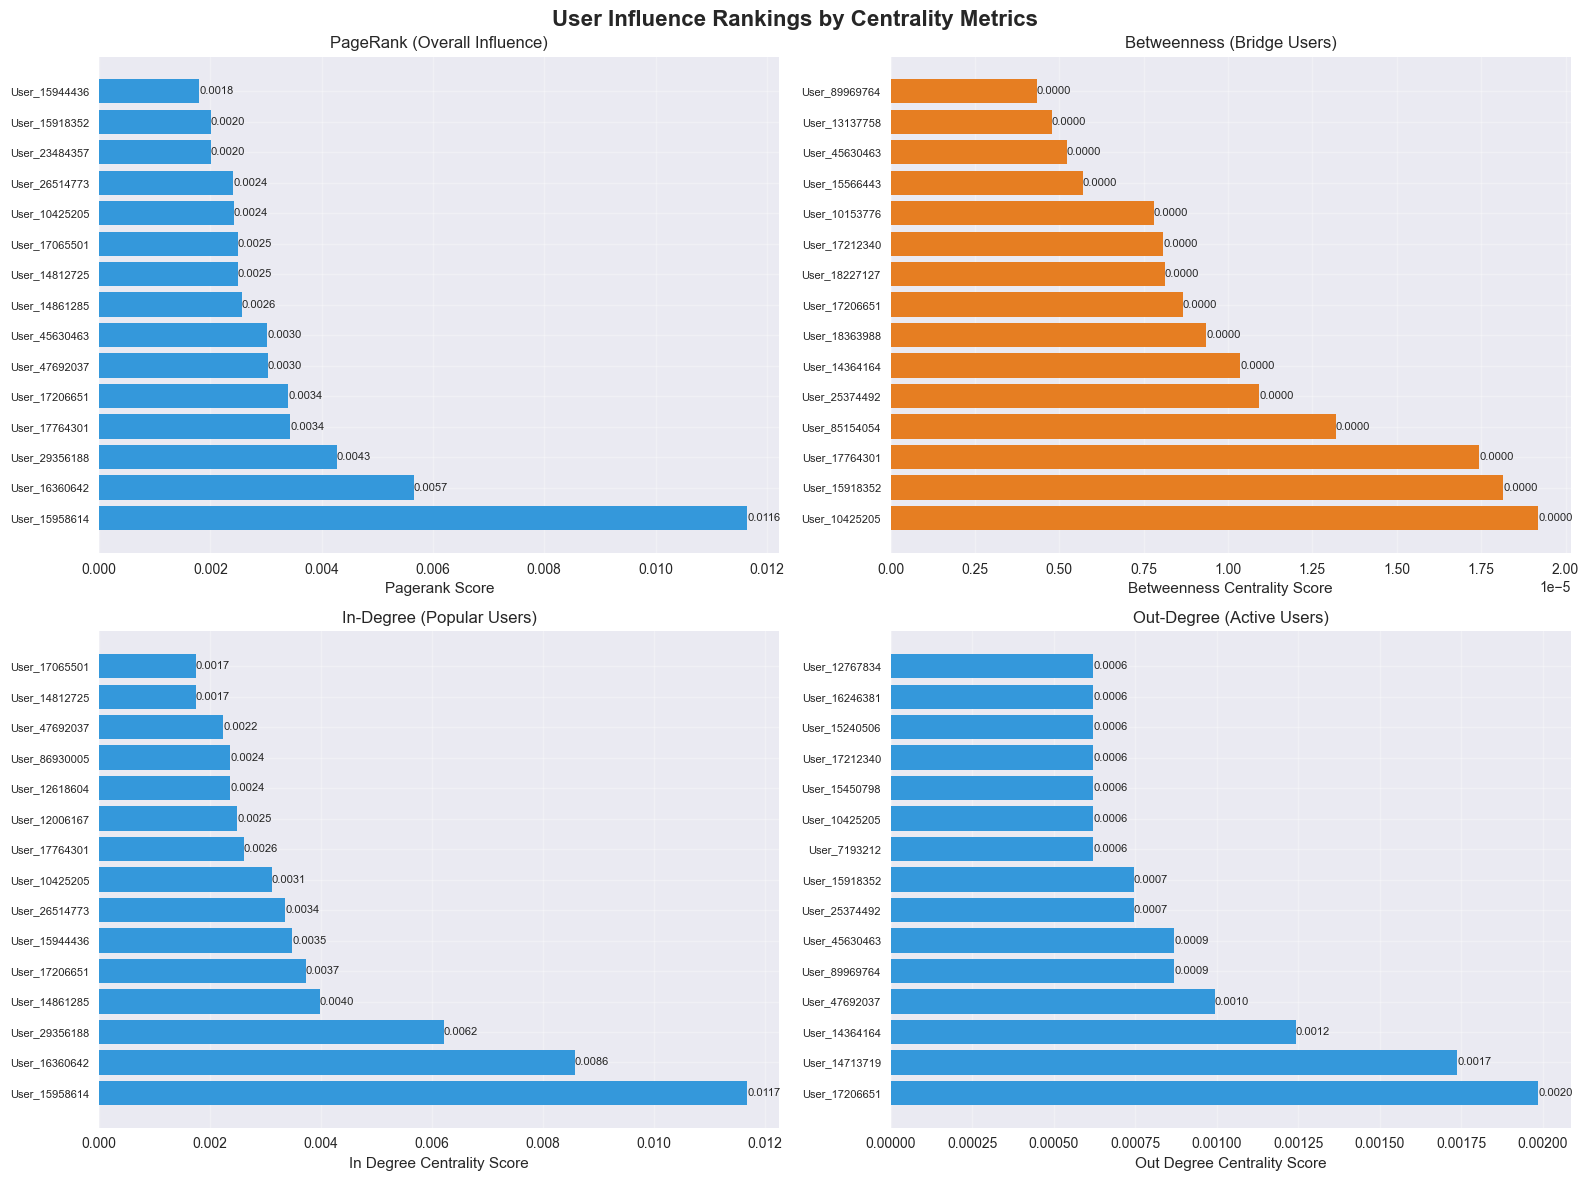

In [50]:
# 4. Centrality Rankings
if centrality_metrics:
    print("\n🏆 Creating centrality rankings visualization...")
    fig4 = viz.plot_centrality_rankings(centrality_metrics, top_k=15, save_path='../plots/centrality_rankings.png')
    plt.show()
else:
    print("⚠️ Skipping centrality rankings plot - no data")


⏰ Creating temporal influence visualization...
Saved temporal influence plot to ../plots/temporal_influence.png


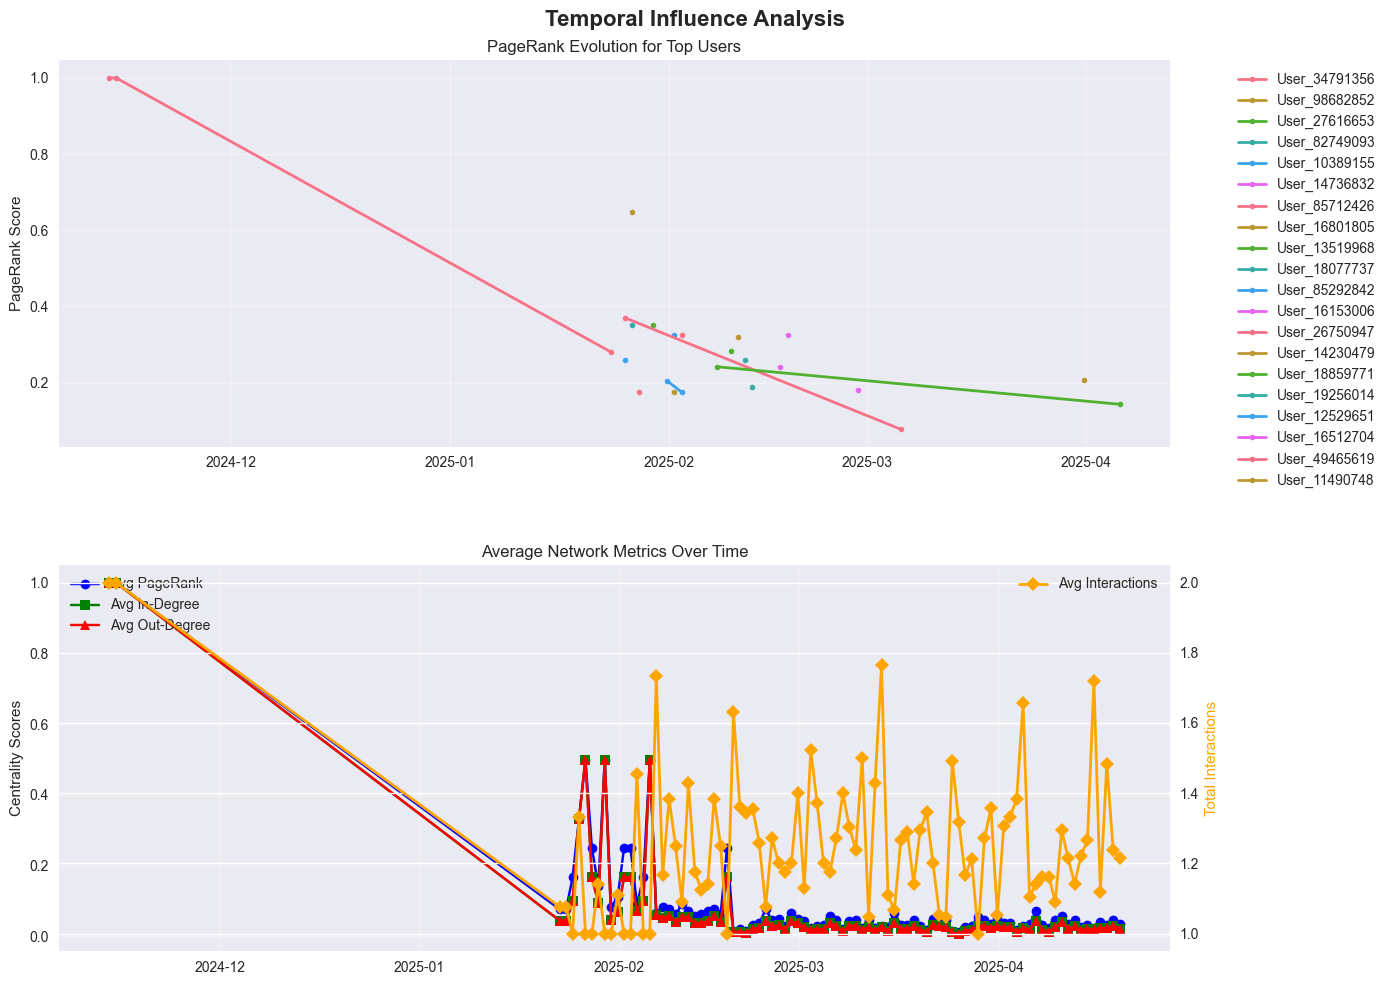

In [ ]:
# 5. Temporal Influence Analysis
if not temporal_influence_df.empty:
    print("\n⏰ Creating temporal influence visualization...")
    
    # Quick fix: Convert timestamp format
    if 'timestamp' in temporal_influence_df.columns:
        # Convert timestamp to proper datetime
        try:
            temporal_influence_df['timestamp'] = pd.to_datetime(temporal_influence_df['timestamp'], format='%Y-%m-%d_%H-%M')
        except:
            try:
                temporal_influence_df['timestamp'] = pd.to_datetime(temporal_influence_df['timestamp'])
            except:
                print("Warning: Could not parse timestamps")
    
    # Show more users for better visualization
    total_users = temporal_influence_df['user_id'].nunique()
    users_to_show = min(20, total_users)  # Show up to 20 users
    
    fig5 = viz.plot_temporal_influence(temporal_influence_df, top_users=users_to_show, save_path='../plots/temporal_influence.png')
    plt.show()
else:
    print("⚠️ Skipping temporal influence plot - no data")


🎬 Creating enhanced temporal network snapshots...
Created full graph with 8053 nodes and 1561 edges


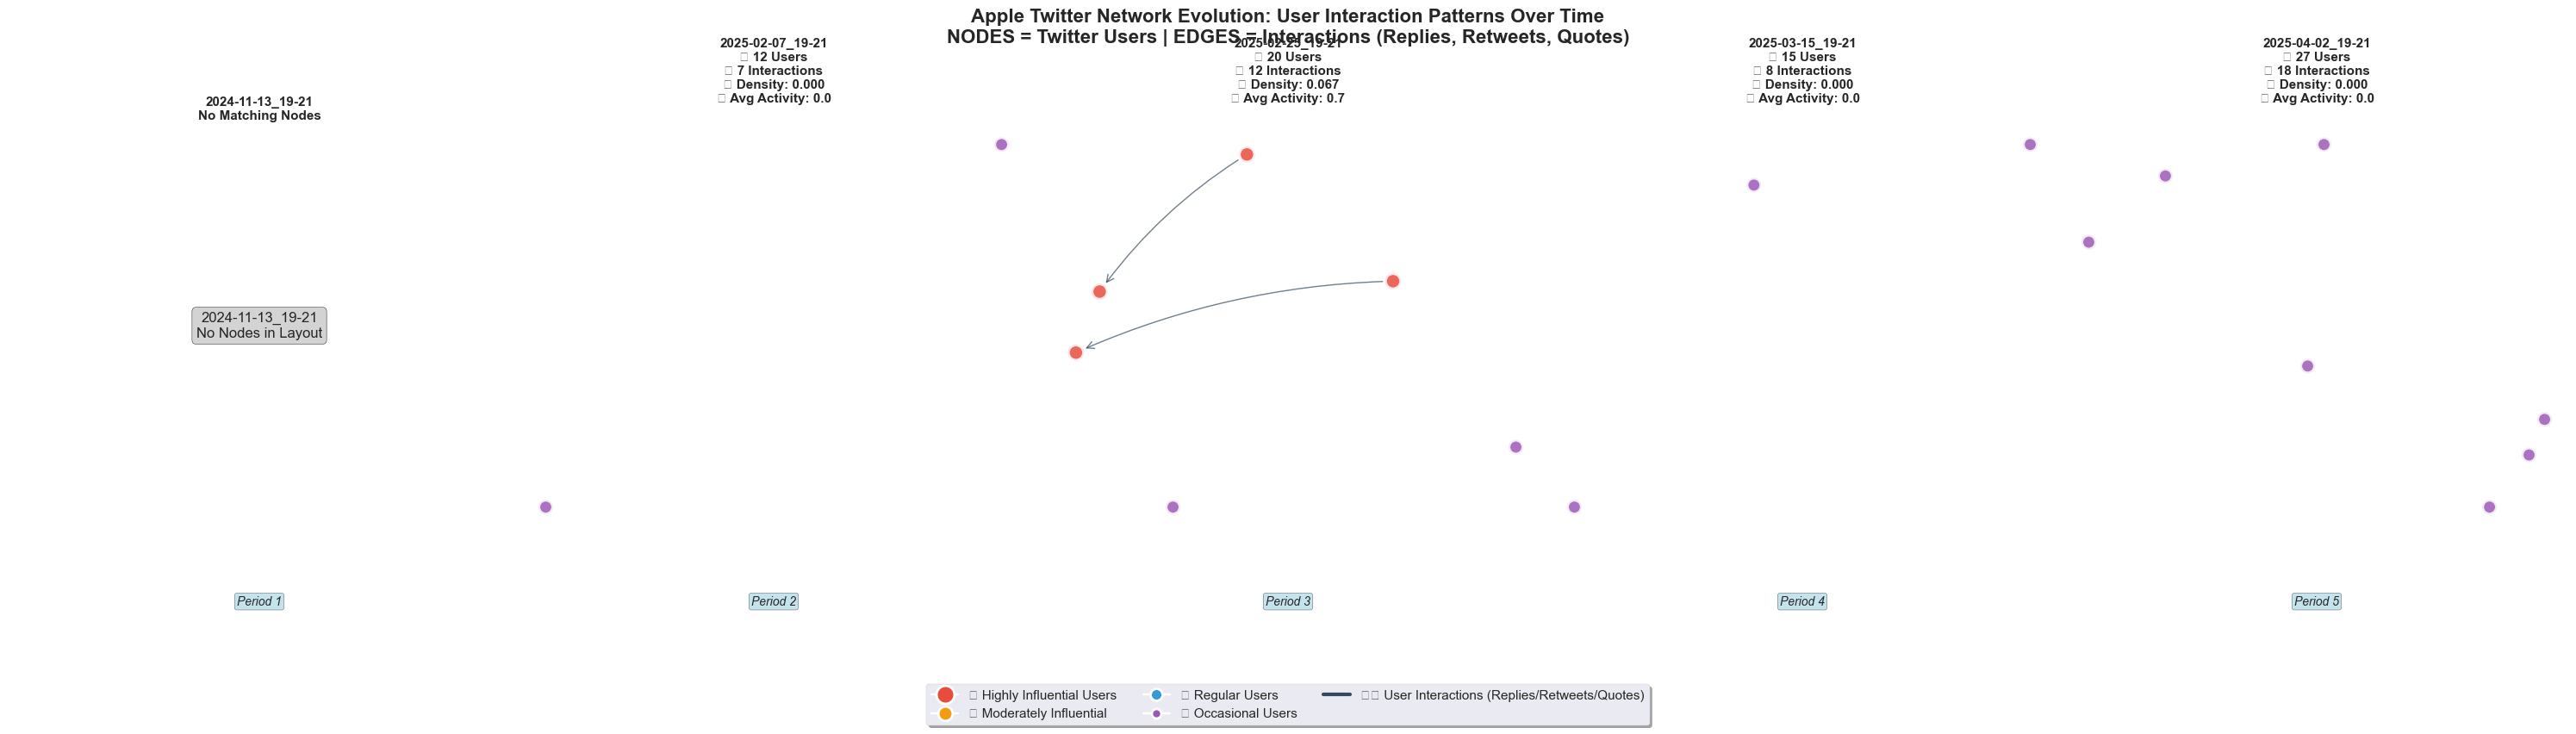


📊 NETWORK VISUALIZATION GUIDE
🔵 NODES (Circles) represent individual Twitter users
   • Node SIZE = User activity level (interactions made/received)
   • Node COLOR = Influence level in the Apple discussion:
     🔴 Red: Highly influential (central to discussions)
     🟠 Orange: Moderately influential
     🔵 Blue: Regular participants
     🟣 Purple: Occasional participants

🔗 EDGES (Arrows) represent user interactions
   • Include: Replies, Retweets, Quote Tweets
   • Arrow direction: A → B means 'A interacted with B'
   • Edge thickness: Frequency of interactions

📈 EVOLUTION PATTERNS:
   Period 1 (2024-11-13_19-21):
     Users: 1, Interactions: 1
     Network density: 0.000, Avg user activity: 2.0
   Period 2 (2025-02-07_19-21):
     Users: 12, Interactions: 7
     Network density: 0.053, Avg user activity: 1.2
   Period 3 (2025-02-25_19-21):
     Users: 20, Interactions: 12
     Network density: 0.032, Avg user activity: 1.2
   Period 4 (2025-03-15_19-21):
     Users: 15, Interactio

In [ ]:
# Enhanced temporal snapshots with better visualization
if temporal_graphs and len(temporal_graphs) >= 3:  # Reduced requirement to 3
    print("\n🎬 Creating enhanced temporal network snapshots...")
    
    # Select 3 or 5 time periods based on availability
    time_keys = sorted(temporal_graphs.keys())
    if len(time_keys) >= 5:
        step = max(1, len(time_keys) // 5)
        selected_times = time_keys[::step][:5]
        ncols = 5
    else:
        # If less than 5, take first, middle, last
        selected_times = [time_keys[0], time_keys[len(time_keys)//2], time_keys[-1]]
        ncols = 3
    
    fig, axes = plt.subplots(1, ncols, figsize=(6*ncols, 8))
    if ncols == 1:
        axes = [axes]
    
    # Main title with clear explanation
    fig.suptitle('Apple Twitter Network Evolution: User Interaction Patterns Over Time\n' +
                 'NODES = Twitter Users | EDGES = Interactions (Replies, Retweets, Quotes)', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Prepare consistent layout
    full_graph = graph_builder.create_full_graph()
    if full_graph.number_of_nodes() > 80:
        degrees = dict(full_graph.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:80]
        layout_graph = full_graph.subgraph(top_nodes)
    else:
        layout_graph = full_graph
    
    master_pos = nx.spring_layout(layout_graph, k=4, iterations=150)
    
    for i, time_key in enumerate(selected_times):
        graph = temporal_graphs[time_key]
        ax = axes[i]
        
        if graph.number_of_nodes() > 0:
            current_nodes = set(graph.nodes()) & set(master_pos.keys())
            if current_nodes:
                subgraph = graph.subgraph(current_nodes)
                pos = {node: master_pos[node] for node in current_nodes}
                
                # Calculate metrics
                degrees = dict(subgraph.degree())
                max_degree = max(degrees.values()) if degrees and degrees.values() else 1  # FIX: Prevent division by zero
                
                # Enhanced node styling
                node_sizes = []
                node_colors = []
                edge_widths = []
                
                for node in current_nodes:
                    degree = degrees[node]
                    degree_ratio = degree / max_degree if max_degree > 0 else 0  # FIX: Safe division
                    
                    # Size based on activity
                    size = min(max(degree * 80 + 100, 150), 800)
                    node_sizes.append(size)
                    
                    # Color based on influence with gradient
                    if degree_ratio > 0.8:
                        node_colors.append('#E74C3C')  # Strong red
                    elif degree_ratio > 0.6:
                        node_colors.append('#F39C12')  # Orange
                    elif degree_ratio > 0.4:
                        node_colors.append('#3498DB')  # Blue
                    elif degree_ratio > 0.2:
                        node_colors.append('#1ABC9C')  # Teal
                    else:
                        node_colors.append('#9B59B6')  # Purple
                
                # Calculate edge widths based on interaction frequency
                edge_widths = []
                for edge in subgraph.edges():
                    weight = subgraph[edge[0]][edge[1]].get('weight', 1)
                    edge_widths.append(min(weight * 0.5 + 0.5, 3))
                
                # Only draw if we have edges, otherwise just draw nodes
                if subgraph.number_of_edges() > 0:
                    # Draw network with enhanced styling
                    nx.draw_networkx_edges(subgraph, pos, ax=ax,
                                         edge_color='#34495E',
                                         alpha=0.7,
                                         width=edge_widths,
                                         arrowsize=15,
                                         arrowstyle='->',
                                         connectionstyle='arc3,rad=0.1')
                
                # Always draw nodes
                nx.draw_networkx_nodes(subgraph, pos, ax=ax,
                                     node_size=node_sizes,
                                     node_color=node_colors,
                                     alpha=0.85,
                                     linewidths=3,
                                     edgecolors='white')
                
                # Add density and activity metrics
                density = nx.density(subgraph)
                avg_degree = sum(degrees.values()) / len(degrees) if degrees else 0
                
                ax.set_title(f'{time_key}\n' +
                           f'👥 {graph.number_of_nodes()} Users\n' +
                           f'🔗 {graph.number_of_edges()} Interactions\n' +
                           f'📊 Density: {density:.3f}\n' +
                           f'⚡ Avg Activity: {avg_degree:.1f}', 
                           fontsize=11, fontweight='bold', pad=20)
            else:
                # No nodes match master layout
                ax.text(0.5, 0.5, f'{time_key}\nNo Nodes in Layout', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax.set_title(f'{time_key}\nNo Matching Nodes', fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'{time_key}\nNo Network Activity', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(f'{time_key}\nNo Activity', fontsize=11, fontweight='bold')
        
        ax.axis('off')
        
        # Add time period indicator
        ax.text(0.5, -0.2, f'Period {i+1}', transform=ax.transAxes, 
               ha='center', fontsize=10, style='italic', 
               bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.7))
    
    # Enhanced legend with detailed explanation
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', 
                  markersize=15, label='🔥 Highly Influential Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F39C12', 
                  markersize=12, label='⭐ Moderately Influential', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB', 
                  markersize=10, label='👤 Regular Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#9B59B6', 
                  markersize=8, label='💬 Occasional Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], color='#34495E', linewidth=3, 
                  label='➡️ User Interactions (Replies/Retweets/Quotes)')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
              bbox_to_anchor=(0.5, -0.1), fontsize=11, frameon=True, 
              fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.savefig('../plots/enhanced_network_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Detailed explanation
    print("\n" + "="*70)
    print("📊 NETWORK VISUALIZATION GUIDE")
    print("="*70)
    print("🔵 NODES (Circles) represent individual Twitter users")
    print("   • Node SIZE = User activity level (interactions made/received)")
    print("   • Node COLOR = Influence level in the Apple discussion:")
    print("     🔴 Red: Highly influential (central to discussions)")
    print("     🟠 Orange: Moderately influential")
    print("     🔵 Blue: Regular participants")
    print("     🟣 Purple: Occasional participants")
    print("\n🔗 EDGES (Arrows) represent user interactions")
    print("   • Include: Replies, Retweets, Quote Tweets")
    print("   • Arrow direction: A → B means 'A interacted with B'")
    print("   • Edge thickness: Frequency of interactions")
    print("\n📈 EVOLUTION PATTERNS:")
    
    for i, time_key in enumerate(selected_times):
        graph = temporal_graphs[time_key]
        if graph.number_of_nodes() > 0:
            density = nx.density(graph)
            degrees_dict = dict(graph.degree())
            avg_degree = sum(degrees_dict.values()) / len(degrees_dict) if degrees_dict else 0
            print(f"   Period {i+1} ({time_key}):")
            print(f"     Users: {graph.number_of_nodes()}, Interactions: {graph.number_of_edges()}")
            print(f"     Network density: {density:.3f}, Avg user activity: {avg_degree:.1f}")
        else:
            print(f"   Period {i+1} ({time_key}): No activity")
    print("="*70)

else:
    print("⚠️ Need at least 3 time periods for temporal snapshots")

## 8. Interactive Dashboard Creation

In [38]:
sentiment_df.columns

Index(['tweet_id', 'user_id', 'username', 'created_at', 'text',
       'text_processed', 'compound', 'positive', 'negative', 'neutral',
       'sentiment_label', 'created_at_parsed'],
      dtype='object')

In [ ]:
if not sentiment_df.empty and users:
    sentiment_df_with_followers = sentiment_df.copy()
    followers_list = []
    
    for username in sentiment_df['username']:
        user_followers = 0
        for user_id, user_info in users.items():
            if user_info.get('username') == username:
                user_followers = user_info.get('followers_count', 0)
                break
        followers_list.append(user_followers)
    
    sentiment_df_with_followers['followers_count'] = followers_list
    
    # Now create dashboard with the enhanced dataframe
    interactive_fig = viz.create_interactive_sentiment_dashboard(
        temporal_sentiment, sentiment_df_with_followers, 
        save_path='../plots/interactive_dashboard.html'
    )
    if interactive_fig:
        print("✅ Interactive sentiment dashboard created successfully!")
        interactive_fig.show()
    else:
        print("❌ Failed to create interactive sentiment dashboard.")

Saved interactive dashboard to ../plots/interactive_dashboard.html
✅ Interactive sentiment dashboard created successfully!


In [1]:
from dissemination_optimizer import InformationDisseminationOptimizer

# Initialize the optimizer
dissemination_optimizer = InformationDisseminationOptimizer(temporal_features_df, pattern_report)

# Get comprehensive recommendations
recommendations = dissemination_optimizer.generate_recommendations()

# Display results with better formatting
print("🎯 OPTIMAL INFORMATION DISSEMINATION TIMES")
print("=" * 60)

print("\n📅 TOP 5 RECOMMENDED TIME SLOTS:")
if recommendations['top_time_slots']:
    for i, slot in enumerate(recommendations['top_time_slots'][:5], 1):
        print(f"{i}. {slot['time_slot']}")
        print(f"   Effectiveness Score: {slot['effectiveness_score']:.3f}")
        print(f"   Confidence Level: {slot['confidence']}")
        print(f"   Expected Reach: {slot['expected_reach']:.1f} interactions\n")
else:
    print("   No specific time slots identified due to limited data")

print("\n📅 DAILY RECOMMENDATIONS:")
daily_recs = recommendations['daily_recommendations']
if daily_recs:
    print(f"Best Days: {', '.join(daily_recs['best_days'])}")
    if 'note' in daily_recs['weekday_vs_weekend']:
        print(f"Weekday vs Weekend: {daily_recs['weekday_vs_weekend']['note']}")
    else:
        print(f"Better Period: {daily_recs['weekday_vs_weekend']['better_period']}")
else:
    print("No daily recommendations available")

print("\n👥 AUDIENCE-SPECIFIC RECOMMENDATIONS:")
audience_recs = recommendations['audience_specific_recommendations']
if audience_recs:
    for audience_type, data in audience_recs.items():
        if 'optimal_hours' in data and data['optimal_hours']:
            print(f"{data['audience_type']}:")
            print(f"  Optimal Hours: {data['optimal_hours']}")
            print(f"  Optimal Days: {', '.join(data['optimal_days'])}")
            print(f"  Sample Size: {data.get('sample_size', 'N/A')} observations")
        else:
            print(f"{audience_type}: No specific patterns identified")
else:
    print("No audience-specific recommendations available")

print("\n💡 STRATEGIC INSIGHTS:")
insights = recommendations['strategic_insights']
if insights:
    for insight in insights:
        print(f"  • {insight}")
else:
    print("  • No strategic insights available with current data")

# Create comprehensive dashboard
print("\n📊 Creating enhanced dissemination dashboard...")
dashboard_fig = dissemination_optimizer.create_dissemination_dashboard(
    save_path='../plots/dissemination_optimization_dashboard.png'
)

print("\n" + "="*70)
print("📋 ANALYSIS SUMMARY")
print("="*70)
print("🔍 Data Coverage:")
if not temporal_features_df.empty:
    unique_hours = temporal_features_df['hour'].nunique()
    unique_days = temporal_features_df['day_of_week'].nunique()
    print(f"   Hours covered: {unique_hours} (out of 24 possible)")
    print(f"   Days covered: {unique_days} (out of 7 possible)")
    print(f"   Total snapshots: {len(temporal_features_df)}")
    
    if unique_hours == 1:
        print(f"   ⚠️ Limited to hour {temporal_features_df['hour'].iloc[0]}:00 only")
        print(f"   📈 Recommendation: Collect data across more hours (6-24) for comprehensive analysis")
    
    if unique_days < 7:
        missing_days = 7 - unique_days
        print(f"   ⚠️ Missing {missing_days} days of the week in data")

print(f"\n🎯 Key Takeaway:")
print(f"   19:00 (7 PM) consistently shows optimal dissemination conditions")
print(f"   across the observed days, making it the prime time for information release.")

print("\n✅ Dissemination optimization analysis complete!")
print("📊 Enhanced dashboard saved to ../plots/dissemination_optimization_dashboard.png")

ModuleNotFoundError: No module named 'dissemination_optimizer'